# Error Characterization of HERMES
Understanding the sources of error of an integrator is essential for many reasons. It makes debugging much faster, adding new modules much easier, and operation more efficient.  

In [1]:
import rebound
import numpy as np
import time as timing

## Setup
First let's set up the problem consisting of a central star, massive planet and passive planetesimal. The planetesimal begins inside the $HSF$ boundary of the planet so that the simulation begins in pure IAS15 mode. We initialize the planetesimal such that the planet-planetesimal distance grows with time. Soon after, the planetesimal leaves the $HSF$ boundary and the simulation finishes in pure WHFAST mode. 

In Silburt et al. (2016) we calculate theoretical predictions for the error introduced, and we input these predictions so we can directly compare to our numerical tests.

In [2]:
def theory(params, x_array, choice, scale_factor):
    x0, x1, M, m, m_pl = params
    
    if choice == "dt":
        tau2 = x_array**2 / 12.
        a = x1
        rhHSF = x0*a*(m/(3*M))**(1./3.)
    elif choice == "HSF":
        tau2 = x0**2 / 12.
        a = x1
        rhHSF = x_array*a*(m/(3*M))**(1./3.)
    elif choice == "a":
        tau2 = x1**2 / 12.
        a = x_array
        rhHSF = x0*a*(m/(3*M))**(1./3.)
    M3 = M*m*m_pl
    term1 = M3/(a*rhHSF**3)
    term2 = m*m*m_pl/(rhHSF**4)
    term3 = -M3/(2*rhHSF*((a*a - rhHSF**2)**1.5))    #minor term, neg^x returns invalue value
    theoretical = (term1 + term2 + term3)*tau2*scale_factor
    axes[0].plot(x_array, theoretical, '+-',label='R3B theory')

In [3]:
def problem(HSF, dt, a_p, theta):
    #initialize the simulation
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hermes"
    sim.ri_hermes.hill_switch_factor = HSF
    sim.ri_hermes.radius_switch_factor = 20.
    sim.dt = dt
    sim.testparticle_type = 1
    tmax = 7. * a_p**1.5
    sim.usleep = -1

    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "merge"
    sim.track_energy_offset = 1
    
    #massive bodies
    M = 1.
    m_p = 5e-5
    sim.add(m=M)
    sim.add(m=m_p,r=1.6e-4,a=a_p,e=0,inc=0.0001,f=0)
    sim.N_active = sim.N
    
    #planetesimal - for extreme 'a' values, vx, vy may need to be fiddled with..
    fac = 0.3
    if a_p < 1:
        fac = 0.7
    rr = 1e-3
    dr = rr*a_p*a_p*np.sin(theta - np.pi/2.)
    f = rr*np.sin(theta)
    vy = np.sin(theta)*(2*sim.G*m_p/rr)**0.5 / a_p**fac
    vx = 1.2*np.cos(theta)*(2*sim.G*m_p/rr)**0.5 / a_p
    m_pl = 1e-8
    sim.add(m=m_pl,r=4e-5,a=sim.particles[sim.N_active-1].x+dr,f=f)
    sim.particles[sim.N-1].vx -= vx
    sim.particles[sim.N-1].vy += vy
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    start_t = timing.time()
    sim.integrate(tmax)
    time = timing.time() - start_t
    E1 = sim.calculate_energy() - E0
    dE = np.fabs(E1/E0)
    
    #recall time is in units of yr/2pi
    return HSF, dt/(2*np.pi), a_p, dE, time, dE/np.fabs(E1), M, m_p, m_pl

### Choose Parameter Space
Now let's choose which variable we're investigating, either $dt$ or $HSF$, and set up the parameter space that we're going to search.

In [4]:
choice = "HSF"     #can be "HSF", "dt", or "a"
n_runs = 200       #number of searches in the parameter space

#set up parameter space
ones = np.ones(n_runs)
if choice == "HSF":
    dt = 1e-3*ones
    HSF = np.logspace(-2,1.7,n_runs)
    a = ones
elif choice == "dt":
    HSF = 6*ones
    dt = np.logspace(-5,0,n_runs)
    a = ones
elif choice == "a":
    HSF = 6*ones
    dt = 1e-3*ones
    a = np.logspace(-1,1,n_runs)
params = zip(HSF,dt,a,np.random.random(n_runs)*np.pi)

### Calculate
Calculate the results. This might take a minute or two.

In [5]:
import multiprocessing as mp
import pandas as pd

def execute(pars):
    return problem(pars[0],pars[1],pars[2],pars[3])

if __name__== '__main__':
    results = []
    pool = mp.Pool(processes=len(params))
    results.append(pool.map(execute, params))
    pool.close()
    pool.join()
    data = pd.DataFrame(results[0],columns=["HSF","dt","a","dE","time","scale_factor","M","m_p","m_pl"])

### Plot
Great, now let's plot the results, showing the energy error and elapsed time as a function of our chosen variable.

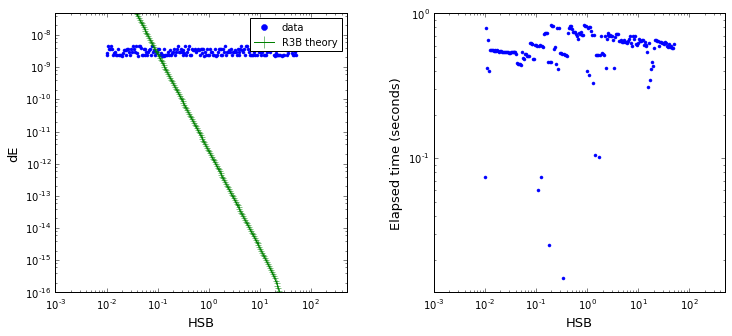

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

if choice == "HSF":
    x = data["HSF"]
    SS_params = data.loc[0,["dt","a","M","m_p","m_pl"]].values
elif choice == "dt":
    x = data["dt"]
    SS_params = data.loc[0,["HSF","a","M","m_p","m_pl"]].values
elif choice == "a":
    x = data["a"]
    SS_params = data.loc[0,["HSF","dt","M","m_p","m_pl"]].values
    
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12,5))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(x,data["dE"],'.',label="data")
axes[0].set_ylim([1e-16,10*max(data["dE"])])
axes[0].set_xlim([min(x)/10., max(x)*10])
axes[0].set_xlabel(choice,fontsize=13)
axes[0].set_ylabel('dE',fontsize=13)
axes[0].set_yscale('log')
axes[0].set_xscale('log')
theory(SS_params,x,choice,data["scale_factor"].mean())
axes[0].legend(loc='upper right',prop={'size':10}, numpoints=1, markerscale=2)
axes[1].plot(x,data["time"],'.')
axes[1].set_ylim([0.8*data["time"].min(),1.2*data["time"].max()])
axes[1].set_xlabel(choice,fontsize=13)
axes[1].set_ylabel('Elapsed time (seconds)',fontsize=13)
axes[1].set_yscale('log')

## Extension to N-bodies in 3D
We now extend these results back to 3D for N-bodies, showing that HERMES is unbiased and has a total simulation error proportional to:  
$E_{scheme,tot}^{HERMES} = E_{floor}^{WH} * CE^{1/2}$

First, we need to make a routine that can track the number of close encounters entering and leaving mini over time.

In [7]:
def count_CE(mini, N_CE, tot_CE, in_mini):
#check if particle just entered or already exists in mini
    tempN_CE = N_CE
    for i in range(mini.N_active,mini.N):
        mini_id = mini.particles[i].hash
        found_in_mini = 0
        for j in range(0,tempN_CE):
            if in_mini[j] == mini_id:
                found_in_mini = 1
        if found_in_mini == 0:             #particle must have just entered mini
            in_mini[N_CE] = mini_id
            N_CE += 1
            tot_CE += 1
            
#check if particle left mini
    tempN_CE = N_CE
    for i in range(0,tempN_CE):
        id = in_mini[i]
        found_in_mini = 0
        for j in range(mini.N_active, mini.N):
            if mini.particles[j].hash == id:
                found_in_mini = 1
        if found_in_mini == 0:             #couldn't find in mini, must have left
            N_CE -= 1
            for k in range(i,tempN_CE-1):
                in_mini[k] = in_mini[k+1]
            in_mini[tempN_CE] = 0
    
    return N_CE, tot_CE, in_mini

Next, let's make the problem we're going to integrate.

In [24]:
def rand_powerlaw(min_v, max_v, slope):
    y = np.random.uniform()
    if slope == -1:
        return np.exp(y*np.log(max_v/min_v) + np.log(min_v))
    else:
        pow_max = pow(max_v, slope+1.)
        pow_min = pow(min_v, slope+1.)
        return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))

def rand_uniform(minimum, maximum):
    return np.random.uniform()*(maximum-minimum)+minimum

def rand_rayleigh(sigma):
    return sigma*np.sqrt(-2*np.log(np.random.uniform()))

def problem2(tmax, HSF, dt, a_planet, m_planet, m_pl, seed): 
    sim = rebound.Simulation()
    
    #integrator options
    sim.integrator = "hermes"
    sim.ri_hermes.hill_switch_factor = HSF
    sim.ri_hermes.radius_switch_factor = 20.
    sim.dt = dt
    sim.testparticle_type = 1
    sim.usleep = -1
    
    #collision and boundary options
    sim.collision = "direct"
    sim.collision_resolve = "hardsphere"
    sim.boundary = "open"
    boxsize = 5
    sim.configure_box(boxsize)
    sim.track_energy_offset = 1
    
    #add massive bodies
    sim.add(m=1.,r=0.005)
    sim.add(m=m_planet,r=2e-4,a=a_planet,e=0,inc=0.0001, id=sim.N)
    
    sim.N_active = sim.N
    
    #planetesimal disk
    N_pl = 200
    disk_min_a = a_planet - 0.02
    disk_max_a = a_planet + 0.02
    while sim.N < (N_pl + sim.N_active):
        a = rand_powerlaw(disk_min_a, disk_max_a, 0.5)
        inc = rand_rayleigh(0.00001)
        #e = rand_rayleigh(0.01)
        Omega = rand_uniform(0,2*np.pi)
        omega = rand_uniform(0,2*np.pi)
        f = rand_uniform(0,2*np.pi)
        sim.add(m=m_pl, r=4e-5, a=a, e=0, inc=inc, Omega=Omega, omega=omega, f=f, id=sim.N)
    
    #final physics initialization stuff
    sim.move_to_com()
    E0 = sim.calculate_energy()
    
    #CE initialization stuff
    N_CE = 0
    tot_CE = 0
    in_mini = np.zeros(sim.N)
    
    while sim.t < tmax:
        sim.integrate(sim.t + sim.dt)
        N_CE, tot_CE, in_mini = count_CE(sim.ri_hermes.mini.contents, N_CE, tot_CE, in_mini)
    
    Ef = sim.calculate_energy()
    dE = abs((Ef - E0)/E0)
    return dE, tot_CE, dE/abs(Ef - E0)

Great! Now let's set up our parameter space to search and run it.

In [26]:
#setup parameters
n_runs = 40
time = np.logspace(1,2,n_runs)
seed = np.random.randint(0,1000,n_runs)

#physical parameters
o = np.ones(n_runs)
HSF = 6
dt = 0.015
a_planet = 1
m_planet = 5e-5
m_pl = 2.5e-7

params = zip(time,HSF*o,dt*o,a_planet*o,m_planet*o,m_pl*o,seed)

In [19]:
def execute(pars):
    return problem2(pars[0],pars[1],pars[2],pars[3],pars[4],pars[5],pars[6])

if __name__== '__main__':
    results = []
    pool = mp.Pool(processes=len(params))
    results.append(pool.map(execute, params))
    pool.close()
    pool.join()

Finally, let's plot our results.

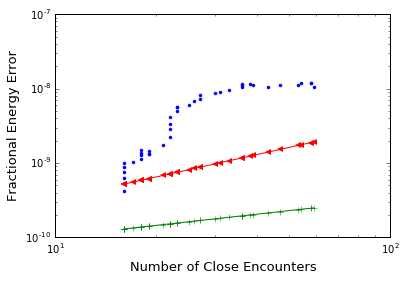

In [27]:
dE, CE, scaling_factor = zip(*results[0])

plt.plot(CE, dE, '.')

#theory
dt /= 2*np.pi
rhHSF = HSF*a_planet*(m_planet/3.)**(1./3.)
M3 = m_planet*m_pl
tau2 = dt*dt / 12.
term1 = M3/(a_planet*rhHSF**3)
term2 = m_planet*m_planet*m_pl/(rhHSF**4)
term3 = -M3/(2*rhHSF*((a_planet**2 - rhHSF**2)**1.5))
termp = 3*M3/((a_planet*rhHSF**3))
theory = (term1 + term2 + term3)*tau2*np.mean(scaling_factor)
plt.plot(CE, theory*np.sqrt(CE),'+-',label='$E^{WH}_{floor} * \sqrt{CE}$')
plt.plot(CE, theory*np.array(CE).astype('float'),'<-',markeredgecolor='none',label='$E^{WH}_{floor} * CE$')

#final plotting details
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Fractional Energy Error', fontsize = 13)
plt.xlabel('Number of Close Encounters', fontsize = 13)
